In [30]:
"""
QPSK Transmitter + Receiver Simulation

1. Generate bits
2. QPSK modulation
3. Pulse filtering
4. Channel
5. Matched filter
6. Symbol timing synchronization
7. Carrier frequency and phase recovery
8. Demodulation
9. Analysis

TODO: 
- Add to utils.py: BER vs SNR, improve complex signal handling
- Add timing synchronization
- Add multipath effects to channel & equalizer
- Time offset
- Framing? Detect start of frame


Date created: 6/9/25
Author: Cole Delong
"""

'\nQPSK Transmitter + Receiver Simulation\n\n1. Generate bits\n2. QPSK modulation\n3. Pulse filtering\n4. Channel\n5. Matched filter\n6. Symbol timing synchronization\n7. Carrier frequency and phase recovery\n8. Demodulation\n9. Analysis\n\nTODO: \n- Add to utils.py: BER vs SNR, improve complex signal handling\n- Add timing synchronization\n- Add multipath effects to channel & equalizer\n- Time offset\n- Framing? Detect start of frame\n\n\nDate created: 6/9/25\nAuthor: Cole Delong\n'

In [31]:
# Reload imports every time this cell is run
%reload_ext autoreload
%autoreload 2

# Imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

import importlib
import utils
importlib.reload(utils)
from utils import *


# Constants
SPS = int(2)
N_BITS = 10**6
N_SYMBOLS = int(N_BITS/2) + 1       # qpsk: 2 bits/sample, differential coding: +1 symbol
N_RRC_TAPS = SPS*10 + 1
SNR_DB = 10


/home/cdelong/sdr/sdr_notebooks/utils/visualization.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  if show: fig.show()


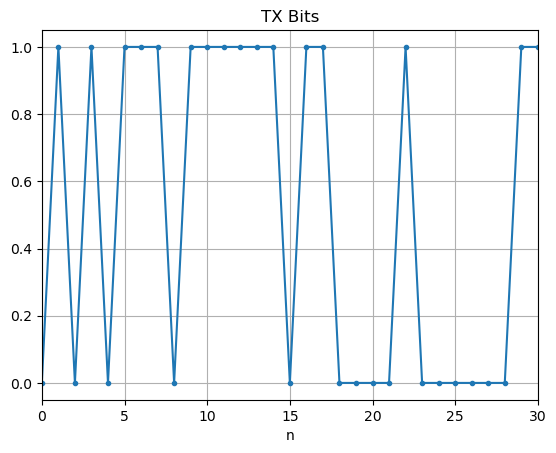

In [32]:
### Generate bits ###
bits_tx = np.random.randint(2, size=N_BITS)
plot_signal(bits_tx, title='TX Bits', xlim=[0, 30])

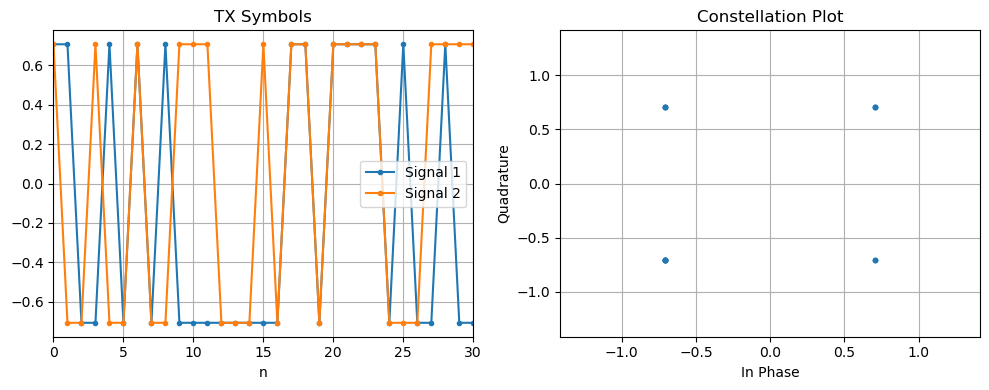

In [45]:
### QPSK modulation ###

# Use differential coding to account for phase ambiguity
sym_tx = diff_encode_psk_symbols(modulate_qpsk(bits_tx))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sym_tx.real, sym_tx.imag, title='TX Symbols', xlim=[0, 30], ax=axs[0])
plot_constellation(sym_tx, ax=axs[1])
plt.tight_layout()
plt.show()

/home/cdelong/sdr/sdr_notebooks/utils/visualization.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  if show: fig.show()


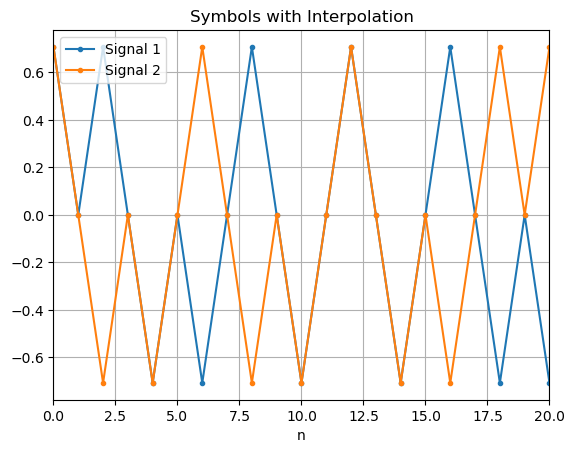

In [34]:
### Pulse filtering ###

# Interpolate by factor of SPS
sym_interp = np.zeros(N_SYMBOLS * SPS, dtype=np.complex128)
sym_interp[::SPS] = sym_tx

plot_signal(sym_interp.real, sym_interp.imag, title='Symbols with Interpolation', xlim=[0, 10*SPS])

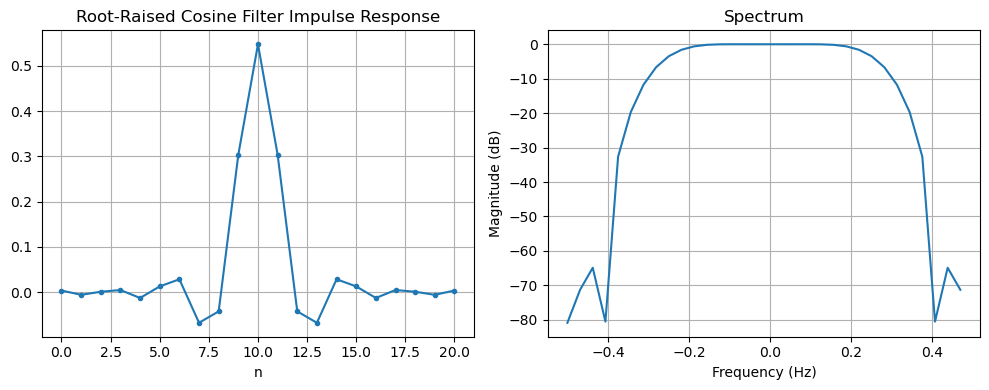

In [35]:
h_rrc = rrc_coef(Ts=SPS, n_taps=N_RRC_TAPS)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(h_rrc.real, title='Root-Raised Cosine Filter Impulse Response', ax=axs[0])
plot_spectrum(h_rrc, ax=axs[1])
plt.tight_layout()
plt.show()

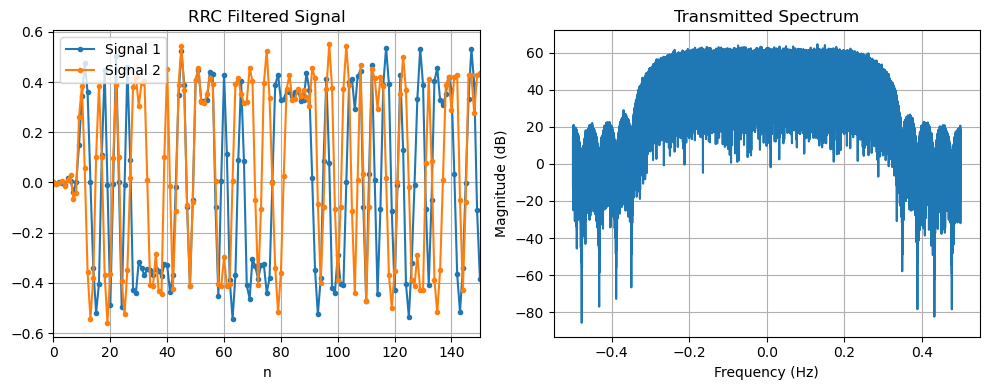

In [36]:
# Convolve signal with RRC filter
sig_tx = np.convolve(sym_interp, h_rrc)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_tx.real, sig_tx.imag, title='RRC Filtered Signal', xlim=[0, 150], ax=axs[0])
plot_spectrum(sig_tx, title="Transmitted Spectrum", ax=axs[1])
plt.tight_layout()
plt.show()

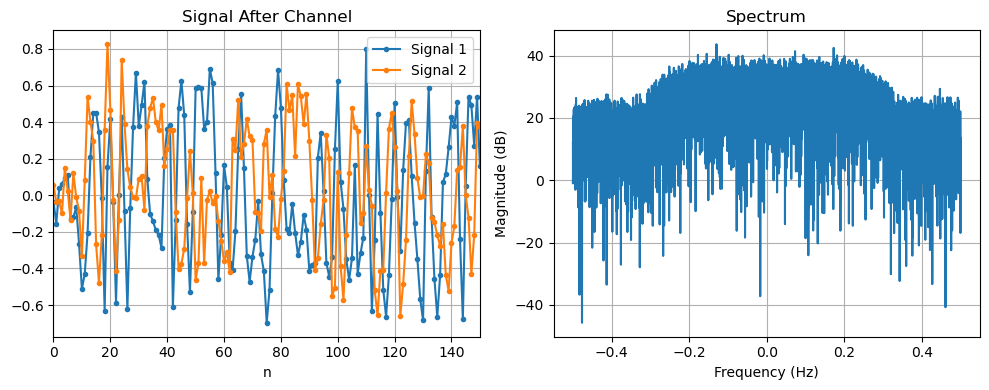

In [37]:
### Channel ###

# Apply CFO
# testing/realistic: 1-5%, aggressive: 10%
sig_chan = apply_cfo(sig_tx, 0.01)

# Apply CPO
sig_chan = apply_cpo(sig_chan)

# Apply symbol timing offset
t_off = SPS*np.random.rand()

# AWGN
sig_rx = apply_awgn(sig_chan, SNR_DB)

# Visualize signal after channel
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_rx.real, sig_rx.imag, title='Signal After Channel', xlim=[0, 150], ax=axs[0])
plot_spectrum(sig_rx, n_samples=2**13, ax=axs[1])
plt.tight_layout()
plt.show()


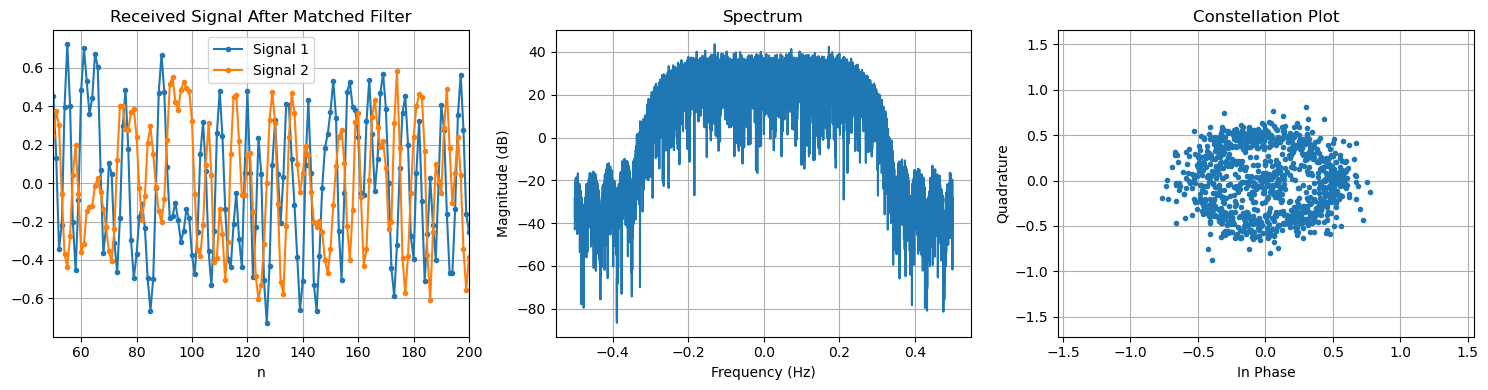

In [46]:
### Matched filter ###
sig_matched = np.convolve(sig_rx, h_rrc)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_signal(sig_matched.real, sig_matched.imag, xlim=[50, 200], title='Received Signal After Matched Filter', ax=axs[0])
plot_spectrum(sig_matched, n_samples=2**13, ax=axs[1])
plot_constellation(sig_matched, n_samples=1000, ax=axs[2])
plt.tight_layout()
plt.show()

# Remove extra samples from convolutions
sig_matched = sig_matched[N_RRC_TAPS-1 : (N_RRC_TAPS-1) * -1]


(-0.4739310474549997-0.23877084871794668j)
(-0.5187426102384998-0.18503056952335964j)
(-0.5215735591041557-0.09325530341216061j)
(-0.4890518545812202+0.02345253951906867j)
(-0.42780545719894675+0.15199054917374633j)
(-0.3444623274865884+0.27925631545529084j)
(-0.24565042597339842+0.39214742826712023j)
(-0.13798391754897402+0.4776470407694738j)
(-0.027249228723547292+0.5278721015318556j)
(0.08205020848066508+0.5428969420081309j)


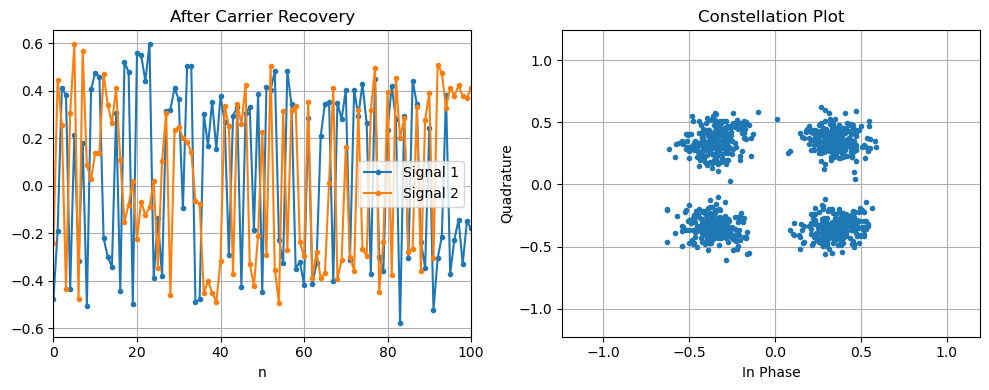

In [51]:
### Symbol Synchronization ###

"""
Gardner: 
- Low complexity
- 2x oversampling fine since sample rate is same for both rx and tx on PlutoSDR
- Better than M&M in lower SNR environments
- Real-time low-latency

cubic interpolation:
- Complexity not bad (better than sinc) when using Farlow structures
- More accurate than lower order quadratic interpolaters
"""

delta_t = 0.0
buf_size = 5
n = np.arange(buf_size)

# for i, val in enumerate(sig_matched[:-buf_size]):
#     interp = scipy.interpolate.CubicSpline(n, sig_matched[i : i+buf_size])

i = 0
interp = scipy.interpolate.CubicSpline(n, sig_matched[i : i+buf_size])
for i in range(10):
    print(interp(i*3/10))

sig_dec = sig_matched[::SPS]


### Carrier Recovery ###
# 2nd Order Costas Loop
K_p = 0.05
K_i = 0.05
costas_loop(sig_dec, K_p, K_i)
sym_rot = sig_dec


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sym_rot.real, sym_rot.imag, title='After Carrier Recovery', xlim=[0, 100], ax=axs[0])
plot_constellation(sym_rot[1000:], n_samples=1000, ax=axs[1])
plt.tight_layout()
plt.show()

    

In [40]:
### Demodulation ###

# Make optimum decision for AWGN channel
bits_rx = demodulate_qpsk(diff_decode_psk_symbols(optimum_decider_qpsk(sym_rot)))

print(f"BER: {np.mean(bits_tx != bits_rx)}")

BER: 0.000157


In [41]:
print(bits_tx[0:15])
print(bits_rx[0:15])
locs = []
for i in range(len(bits_tx)):
    if bits_tx[i] != bits_rx[i]:
        locs.append(i)

print(np.sum(bits_rx != bits_tx))

[0 1 0 1 0 1 1 1 0 1 1 1 1 1 1]
[0 1 0 1 0 1 1 1 0 1 1 1 1 1 1]
157
